***
# Classification
MSDS 7331-407, Lab 2 
*Jenna Ford, Edward Fry, Christian Nava, and Jonathan Tan* 
***

## Table of Contents

<a href='#Section_1'> 1. Introduction </a>  
<a href='#Section_2'> 2. Preparation and Dataset Loading </a>  
<a href='#Section_3'> 3. Data Preparation Part 1 </a>  
<a href='#Section_4'> 4. Data Preparation Part 2 </a>  
<a href='#Section_5'> 5. Modeling and Evaluation 1 </a>  
<a href='#Section_6'> 6. Modeling and Evaluation 2 </a>  
<a href='#Section_7'> 7. Modeling and Evaluation 3 </a>  
<a href='#Section_8'> 8. Modeling and Evaluation 4 </a>  
<a href='#Section_9'> 9. Modeling and Evaluation 5 </a>  
<a href='#Section_10'> 10. Modeling and Evaluation 6 </a>  
<a href='#Section_11'> 11. Deployment </a>  
<a href='#Section_12'> 12. Exceptional Work </a>  

<!-- <a href='#Section_4_a'> &nbsp;&nbsp;&nbsp; a. Missing Values </a>  --> 
<!-- <a href='#Section_4_c_i'> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; i. Cross Street </a>    --> 

<a id = 'Section_1'></a>

## 1. Introduction

For this project our group will continue to use the Los Angeles arrest incidents dataset with arrest incidents dating back to 2010, which can be found [here](https://data.lacity.org/A-Safe-City/Arrest-Data-from-2010-to-Present/yru6-6re4). This dataset contains information about the date, time and location of the incident, demographic data of the person arrested, and information about the type of incident. 

We will be classifying the variables `Arrest Type` (Felony, Misdemeanor, Infraction, Other) and `Descent Code` (Black, Hispanic, White, Other). We feel that being able to classify arrest type could help in prioritizing dispatch calls, especially when there are more calls than officers available to respond. We assume that arrest type is an indicator of the severity of the incident. It is also worth noting that most of the data available for the classification would be available to the dispatcher. For example, someone placing a call to 911 would most likely have a basic description of the offender such as gender, approximate age and ethnicity. The caller would also know the location of the incident and have a brief description of the situation. 

As far as classifying `Descent Code`, we are not trying to make any political statements. However, if this variable can be predicted, what can that tell us? Any information discovered from this could be invetigated further. The information could be used for community outreach programs to help guide and direct efforts where they will make the most impact.

We 10-fold cross validation to test a variety of models. We also adjust model parameters to fine-tune our classification models. 

Model effectiveness will be measured using accuracy. A successful model would ideally exceed the ability of a dispatcher to correctly identify the arrest type. However, we do not have data available for this. To be considered effective, the model should significantly outperform random chance (25%), so we will use accuracy of 75% as the cut-off for identifying if the model is successful.

NEED TO WORK ON MORE AFTER MODELS AND EVALUATION METRICS ARE DETERMINED

<a id = 'Section_2'></a>

## 2. Preparation and Dataset Loading

In [ ]:
# Data manipulation
import numpy as np
import pandas as pd

# Creating training and test sets
import sklearn

# File system management
import os.path

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

#training/test split
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, ShuffleSplit

# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# here we can change some of the parameters interactively
from ipywidgets import widgets as wd
from sklearn.model_selection import cross_val_score, cross_validate

#for weights standardization
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report

from matplotlib import pyplot as plt

# Support vector machines
from sklearn.svm import SVC

import plotly
plotly.offline.init_notebook_mode() # run at the start of every notebook

In [ ]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

In [ ]:
# Constants
DATAPATH_BASE = 'https://machinelearningi.blob.core.windows.net/group-project/'
DATAPATH_SAS_TOKEN = '?sv=2019-02-02&ss=bfqt&srt=sco&sp=rwdlacup&se=2020-04-27T11:12:37Z&st=2020-01-23T04:12:37Z&spr=https&sig=jpIpjrp8dIg9eyUyPpmgTe5yj9i1ZoCSru5kBVHcUO8%3D'
DATAPATH_FILENAME = 'Arrest_Data_from_2010_to_Present.csv'
DATAPATH_SMALL_FILENAME = 'Arrest_Data_from_2010_to_Present_Small.csv'
SUB_SAMPLE_SIZE = 0.01  #subsample of dataframe for svm testing, 1% of data

# Fully qualified paths ready to use
DATA_SOURCE = "".join([DATAPATH_BASE, DATAPATH_FILENAME, DATAPATH_SAS_TOKEN])

# Options
pd.set_option('float_format', '{:.2f}'.format)  # Reign in the scientific notation for reasonable values

# Load data for analysis; only read if needed because the import can take a long time
try:
    if len(df.index) < 1:
        df_raw = pd.read_csv(DATA_SOURCE) # If we get here, the dataframe was empty
except:   
    df_raw = pd.read_csv(DATA_SOURCE) # If we get here, the dataframe did not exist
    

In [ ]:
df = df_raw

print("The dataset has {:,} rows and {:,} columns".format(*df.shape))

<a id = 'Section_3'></a>

## 3. Data Preparation Part 1

*(10 points)*  

*Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.*

The code below is from Lab 1 where we prepared the initial dataset. Here is a summary of the steps in the code below:
* Convert `Time` to a time format and treat missing values and a value of 24:00 as 00:00.
* Drop observations where the age of the individual is under 16. This is due to data issues (probably data entry errors).
* Drop observations where the `Arrest Type Code` is Dependent. The majority of these observations are for individuals aged 15 or less (and have already been removed from the dataset). There are, however, some remaining observations that we believe to be data entry errors.
* Reduce the `Descent Code` classifications to B-Black, H-Hispanic and W-White. Any other ethnicities are grouped into O-Other.
* Create an `Hour` variable because knowing the hour and minute an incident occurred is not critical. A window of time will be more appropriate.
* Create variables for the day of week and month an incident occurred on. Knowing the exact date an incident occurred is not helpful for future classification, but day of week and month may be.
* Drop variables that are not useful for the analysis such as `Location` which has GIS coordinates and description variables that have an associated code variable.

In [ ]:
# Time - filter out 0 and missing
df = df[df['Time'] != 0]
df['Time'] = df['Time'].astype(str) 
df = df[df['Time'] != 'nan']

# Time - Convert float to string. Get rid of decimals. Replace missing or invalid values with '0000'.
df['Time'] = df['Time'].astype(str).str.split(".", expand = True)[0].replace(to_replace = ['2400','nan'], value = '0000') 

# Time - Fill time column with leading zeros to have 4 characters total
df['Time'] = df['Time'].apply(lambda x: '{0:0>4}'.format(x))

# Time - Add colon to Time values by converting attribute to a datetime variable 
df['Time'] = pd.to_datetime(df['Time'], format = '%H%M').dt.time

# Charge Group Code - filter out missing values
df = df.loc[df['Charge Group Code'].notnull()]

# Age - Drop the observations where Age is less than 16
df.drop(df[df['Age'] < 16].index, inplace = True) 

# Arrest Type Code - Drop the observations where Arrest Type Code = 'D'
df.drop(df[df['Arrest Type Code'] == 'D'].index, inplace = True) 

# Descent Code - Re-classify any descent not in (B,H,O,W) into 0
descent_list = ['B','H','O','W']
df['Descent Code'] = np.where(np.isin(df['Descent Code'],descent_list),df['Descent Code'],'O')

# Get hour
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour

# Convert Arrest Date to datetime
df['Arrest Date'] = pd.to_datetime(df['Arrest Date'])

# Extract year, month, and day of week and add to dataframe as new attributes
#df['arrest_year']= df['Arrest Date'].dt.year
df['arrest_month']= df['Arrest Date'].dt.month
try:
    df['arrest_day_of_week'] = df['Arrest Date'].dt.weekday_name
except:
    df['arrest_day_of_week'] = 'monday'

# remove unecessary columns
df.drop(['Cross Street','Charge Description','Charge','Charge Group Description','Time',
         'Arrest Date','Report ID','Address','Area Name','Location'], axis=1, inplace=True)

# Change data types
df['Age'] = df['Age'].astype(np.int8)
df['Reporting District'] = df['Reporting District'].astype(np.str)
df['Area ID'] = df['Area ID'].astype(np.str)
df['Charge Group Code'] = df['Charge Group Code'].astype(np.str)
df['Hour'] = df['Hour'].astype(np.str)
#df['arrest_year'] = df['arrest_year'].astype(np.str)
df['arrest_month'] = df['arrest_month'].astype(np.str)
df['arrest_day_of_week'] = df['arrest_day_of_week'].astype(np.str)

df_lightgbm = df
# print clean dataset
df.info()

The code below prepares the dataset for classification tasks. First, we group `Age` into bins of 10 years and perform integer encoding, since the data is ordinal. Next, we perform one-hot encoding on all categorical variables. We use one-hot encoding here because no natural ordering exists in the values.

In [ ]:
# Create buckets for Age
df['age_range'] = pd.cut(df.Age,[15,25,35,45,55,65,75,1e6],4,labels=[0,1,2,3,4,5,6]) # this creates a new variable
df['age_range'] = df['age_range'].fillna(0)
df['age_range'] = df.age_range.astype(np.int)

# Replace the current Sex atribute with something slightly more intuitive and readable
df['IsMale'] = df['Sex Code']=='M' 
df.IsMale = df.IsMale.astype(np.int)

# Perform one-hot encoding of the categorical data "DOW"
tmp_df = pd.get_dummies(df['arrest_day_of_week'],prefix='DOW',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Perform one-hot encoding of the categorical data "Area ID"
tmp_df = pd.get_dummies(df['Area ID'],prefix='Area',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Perform one-hot encoding of the categorical data "Charge Group Code"
tmp_df = pd.get_dummies(df['Charge Group Code'],prefix='Charge',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Perform one-hot encoding of the categorical data "Hour"
tmp_df = pd.get_dummies(df['Hour'],prefix='Hour',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Perform one-hot encoding of the categorical data "Month"
tmp_df = pd.get_dummies(df['arrest_month'],prefix='Month',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

Since we have 2 classification tasks (`Arrest Type Code` and `Descent Code`), we need 2 datasets. The dataset for classifying `Arrest Type Code` will need to have `Descent Code` one-hot encoded and the dataset for classifying `Descent Code` will need to have `Arrest Type Code` one-hot encoded.

In [ ]:
df_arrest = df
df_descent = df

#Final encoding steps for Arrest Type Code classification dataset
# Encode Arrest Type Code as Categorical
cleanup_arrest = {"Arrest Type Code": {"F": 0, "M": 1, "I": 2, "O":3}}
df_arrest.replace(cleanup_arrest,inplace=True)

# Perform one-hot encoding of the categorical data "Descent Code"
tmp_df = pd.get_dummies(df_arrest['Descent Code'],prefix='Descent',drop_first=True)
df_arrest = pd.concat((df_arrest,tmp_df),axis=1) # add back into the dataframe

df_arrest.drop(['Sex Code','Descent Code','arrest_day_of_week','Area ID','Reporting District','Charge Group Code',
         'Age','Hour','arrest_month'], axis=1, inplace=True)

df_arrest.info()

In [ ]:
#Final encoding steps for Descent Code classification dataset
cleanup_descent = {"Descent Code": {"B": 0, "H": 1, "W": 2, "O":3}}
df_descent.replace(cleanup_descent,inplace=True)

# Perform one-hot encoding of the categorical data "Arrest Type Code"
tmp_df = pd.get_dummies(df_descent['Arrest Type Code'],prefix='Arrest',drop_first=True)
df_descent = pd.concat((df_descent,tmp_df),axis=1) #add back to the dataframe

df_descent.drop(['Sex Code','Arrest Type Code','arrest_day_of_week','Area ID','Reporting District','Charge Group Code',
         'Age','Hour','arrest_month'], axis=1, inplace=True)

df_descent.info()

In [ ]:
print("The Arrest classification dataset set has {:,} rows and {:,} columns".format(*df_arrest.shape))
print("The Descent classification dataset set has {:,} rows and {:,} columns".format(*df_descent.shape))

In [ ]:
# data prep for LightGBM
#don't need to one-hot encode variables for LightGBM, but they do need to be numeric
#still need to get Charge Group Code converted

import lightgbm as lgb

df_lightgbm0 = df_lightgbm.sample(n = int(len(df_lightgbm) * SUB_SAMPLE_SIZE))

df_lightgbm1=df_lightgbm0

cleanup_arrest = {"Arrest Type Code": {"F": 0, "M": 1, "I": 2, "O":3}}
df_lightgbm1.replace(cleanup_arrest,inplace=True)

cleanup_descent = {"Descent Code": {"B": 0, "H": 1, "W": 2, "O":3}}
df_lightgbm1.replace(cleanup_descent,inplace=True)

df_lightgbm1['Area ID'] = df_lightgbm1['Area ID'].astype(np.int)

df['IsMale'] = df['Sex Code']=='M' 
df.IsMale = df.IsMale.astype(np.int)

df_lightgbm1['Hour'] = df_lightgbm1['Hour'].astype(np.int)
df_lightgbm1['arrest_month'] = df_lightgbm1['arrest_month'].astype(np.int)

cleanup_dow = {"arrest_day_of_week": {"Sunday": 1, "Monday": 2, "Tuesday":3, "Wednesday": 4, "Thursday":5, "Friday":6, "Saturday":7}}
df_lightgbm1.replace(cleanup_dow,inplace=True)

#df_lightgbm1['Charge Group Code'] = df_lightgbm1['Charge Group Code'].astype(np.int)

#df_lightgbm1.drop(['Reporting District'], axis=1, inplace=True)
df_lightgbm1.drop(['Sex Code'], axis=1, inplace=True)

df_lightgbm1.info()
#train_data = lgb.Dataset(data, label=label, feature_name=['c1', 'c2', 'c3'], categorical_feature=['c3'])


<a id = 'Section_4'></a>

## 4. Data Preparation Part 2

*(5 points)*

*Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).*

#### Table 1: Description of Final Dataset

| Dataset | Target/Explanatory| Variable Prefix | Variable Suffix Range | Description |
| :-- | :-- | :-- | :-- | :-- |
| Arrest | Target| Arrest Type Code | NA | Felony=0, Misdemeanor=1, Infraction=2, Other=3 |  
| Descent | Target| Descent Code | NA | Black=0, Hispanic=1, White=2, Other=3 | 
| Both | Explanatory| age_range | NA | Age bins: 16-25=0, 25-35=1, 35-45=2, 45-55=3, 55-65=4, 65-75=5, 75+=6|
| Both | Explanatory| IsMale | NA | 0=Female, 1=Male|
| Both | Explanatory| DOW | Saturday-Thursday | Value of 1 indicates the DOW the incident occurred on. DOW_Friday is the comparison and was dropped from the dataset.|
| Both | Explanatory| Area | 2-21 | Value of 1 indicates the Area the incident occurred in. Area_1 is the comparison and was dropped from the dataset.|
| Both | Explanatory| Charge | 2-29, 99, nan | Value of 1 indicates the Charge relating to the incident. Charge_1 is the comparison and was dropped from the dataset.|
| Both | Explanatory| Hour | 1-23 | Value of 1 indicates the Hour the incident occurred. Hour_0 (00:00-00:59 on the 24-hour clock) is the comparison and was dropped from the dataset.|
| Both | Explanatory| Month | 2-12 | Value of 1 indicates the month the incident occurred. Month_1 (January) is the comparison and was dropped from the dataset.|
| Arrest | Explanatory| Descent | H,W,O | Value of 1 indicates the descent of the individual. Descent_H: Hispanic, Descent_W: White and Descent_O: Other. Descent_B (Black) is the comparison and was dropped from the dataset.|
| Descent | Explanatory| Arrest | 1-3 | Value of 1 indicates the type of arrest made. Arrest_1: Misdemeanor, Arrest2: Infraction and Arrest_3: Other. Arrest_0 (Felony) is the comparison and was dropped from the dataset.|

<a id = 'Section_5'></a>

## 5. Modeling and Evaluation 1

*(10 points)*

*Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.*

The metric used for this project is the area under the receiver operating characteristic curve (AUC). The receiver operating characteristic curve (ROC) graphs the performance of a classification model at all classification thresholds; it plots the true positive rate (TPR) against the false positive rate (FPR) as shown in Figure 1.

<h4 align="center">Figure 1: Area Under the Reciever Operating Curve</h4> 
<img src="https://marlin-prod.literatumonline.com/cms/attachment/34661288-1f8f-459e-b8b4-936efc49e9bc/fx1_lrg.jpg" style="width:350px;height:300px"/>

Source: [Journal of Thoracic and Cardiovascular Surgery](https://www.jtcvs.org/article/S0022-5223(18)32875-7/fulltext)

Each curve represents the graph of a single model. Movement along the curve indicates changing the threshold used for classifying a positive instance. The area under the ROC curve measures the two-dimensional area under the ROC curve and is given by the integral of the curve, or the area under the curve (AUC): $$AUC = \int_{0}^{1}TPR(x)dx = \int_{0}^{1}P(A>\tau (x))dx$$

where $x$ is the false positive rate and $A$ is the distribution of scores the model produces for data points that are actually in the positive class.

This metric is measured between 0 and 1. A higher score indicates a better model. Visually, a superior model will graph as a curve above and to the left of another curve. A straight diagonal line beginning at 0 on the bottom left and ending at 1 on the top right indicates a naive model (random guessing). Other metrics such as accuracy are not the best metric for data with imbalanced classes. The Los Angeles City Arrest dataset is imbalanced. 

A model with a high ROC AUC will also have a high accuracy, therefore, the AUC score will be the metric employed in this analysis.


<a id = 'Section_6'></a>

## 6. Modeling and Evaluation 2

*(10 points)*

*Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.*

<a id = 'Section_7'></a>

## 7. Modeling and Evaluation 3

*(20 points)*

*Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!*

In [11]:
df_model1 = df_arrest
df_model1 = df_model1.sample(n = int(len(df_model1) * SUB_SAMPLE_SIZE))

print("The sample has {:,} rows and {:,} columns".format(*df_model1.shape))

The sample has 12,788 rows and 88 columns


In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt


# create variables we are more familiar with
if 'Arrest Type Code' in df_model1:
    y = df_model1['Arrest Type Code'].values # get the labels we want
    del df_model1['Arrest Type Code'] # get rid of the class label
    X = df_model1.values # use everything else to predict!
    
yhat = np.zeros(y.shape) # we will fill this with predictions

scl = StandardScaler()
X = scl.fit_transform(X)

# create cross validation iterator
cv = StratifiedKFold(n_splits=10, random_state=1234)

In [13]:
def per_class_accuracy(ytrue,yhat):
    conf = mt.confusion_matrix(ytrue,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue,yhat, title=''):
    acc_list = per_class_accuracy(ytrue,yhat)
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel('0-Felony, 1-Misdemeanor, 2-Infraction, 3-Other')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,yhat)))
    plt.grid()
    plt.ylim([0,1])
    plt.show()

XGBoost accuracy 0.7980137629027213


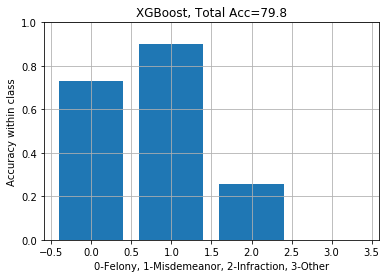

Wall time: 1min 41s


In [14]:
%%time

#KGBoost
import pickle
import xgboost as xgb

import numpy as np
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error

for train, test in cv.split(X,y):
    xgb_model = xgb.XGBClassifier().fit(X[train], y[train])
    yhat[test] = xgb_model.predict(X[test])

total_accuracy = mt.accuracy_score(y, yhat)
print ('XGBoost accuracy', total_accuracy)

plot_class_acc(y,yhat,title="XGBoost")

KNN accuracy 0.7172349077259931


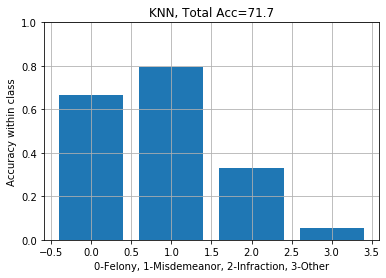

Wall time: 34.5 s


In [15]:
%%time
#KNN for Arrest Type Code

from sklearn.neighbors import KNeighborsClassifier

# get a handle to the classifier object, which defines the type
clf = KNeighborsClassifier(n_neighbors=3)

# now iterate through and get predictions, saved to the correct row in yhat
# NOTE: you can parallelize this using the cross_val_predict method
for train, test in cv.split(X,y):
    clf.fit(X[train],y[train])
    yhat[test] = clf.predict(X[test])

total_accuracy = mt.accuracy_score(y, yhat)
print ('KNN accuracy', total_accuracy)

plot_class_acc(y,yhat,title="KNN")

KNN, pipeline accuracy 0.7120738192055052


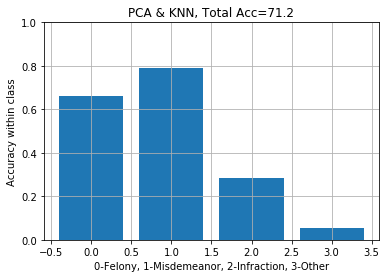

Wall time: 38.3 s


In [16]:
%%time

# PCA and KNN for Arrest Type Code

from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline

# setup pipeline to take PCA, then fit a KNN classifier
clf_pipe = Pipeline(
    [('PCA_1',PCA(n_components=50,svd_solver='randomized')),
     ('CLF_1',KNeighborsClassifier(n_neighbors=3))]
)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X,y):
    clf_pipe.fit(X[train],y[train])
    yhat[test] = clf_pipe.predict(X[test])

total_accuracy = mt.accuracy_score(y, yhat)
print ('KNN, pipeline accuracy', total_accuracy)

plot_class_acc(y,yhat,title="PCA & KNN")

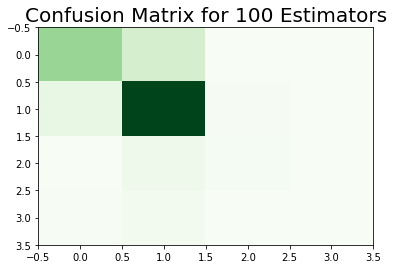

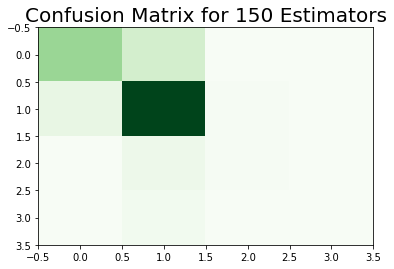

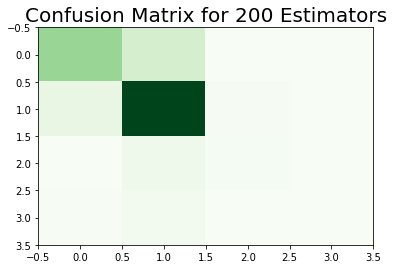

Best accuracy is  0.77713481388802  with  100  estimators in a random forest with PCA
              precision    recall  f1-score   support

           0      0.789     0.671     0.725      4154
           1      0.777     0.899     0.834      7806
           2      0.642     0.228     0.336       545
           3      0.265     0.032     0.057       283

    accuracy                          0.777     12788
   macro avg      0.618     0.457     0.488     12788
weighted avg      0.764     0.777     0.760     12788



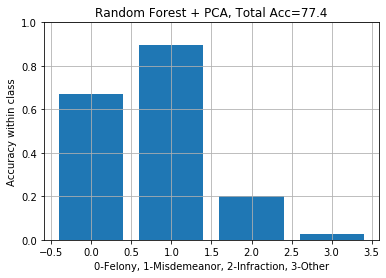

Wall time: 4min 14s


In [17]:
%%time
from sklearn.ensemble import RandomForestClassifier

maxAccPCARF = 0
optimalEstimatorsPCARF = 0
optimalYPCARF = []
optimalYhatPCARF = []
clReport = ''

for i in range(100, 201, 50):
    clf_pipe = Pipeline(
        [('PCA',PCA(n_components=50, svd_solver='randomized')),
         ('CLF',RandomForestClassifier(n_estimators=i, n_jobs=-1))]
    )

    # now iterate through and get predictions, saved to the correct row in yhat
    for train, test in cv.split(X,y):
        clf_pipe.fit(X[train],y[train])
        yhat[test] = clf_pipe.predict(X[test])

    plt.title('Confusion Matrix for {0} Estimators'.format(i), fontsize = 20)
    plt.imshow(mt.confusion_matrix(y, yhat),cmap=plt.get_cmap('Greens'),aspect='auto')
    plt.grid(False)
    plt.show()
        
    total_accuracy = mt.accuracy_score(y, yhat)
    if total_accuracy > maxAccPCARF:
        maxAccPCARF = total_accuracy
        optimalEstimatorsPCARF = i
        optimalYPCARF = y
        optimalYhatPCARF = yhat
        clReport = mt.classification_report(y,yhat,digits=3)

print ('Best accuracy is ', maxAccPCARF, ' with ', optimalEstimatorsPCARF, ' estimators in a random forest with PCA')
print(clReport)
plot_class_acc(optimalYPCARF,optimalYhatPCARF,title="Random Forest + PCA")

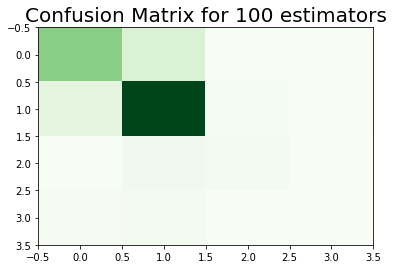

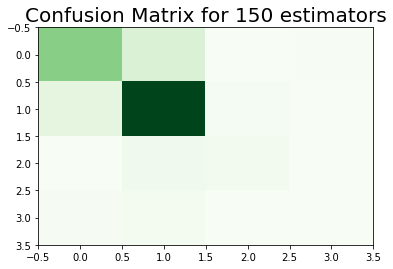

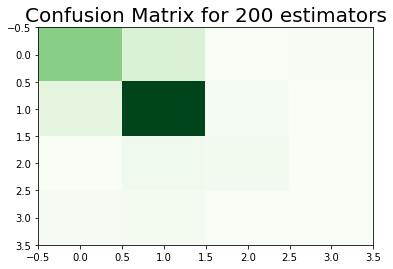

Best accuracy is  0.7861276196434157  with  200  Estimators in a Raw Random Forest
              precision    recall  f1-score   support

           0      0.765     0.721     0.743      4154
           1      0.806     0.873     0.838      7806
           2      0.652     0.409     0.503       545
           3      0.229     0.057     0.091       283

    accuracy                          0.786     12788
   macro avg      0.613     0.515     0.544     12788
weighted avg      0.773     0.786     0.776     12788



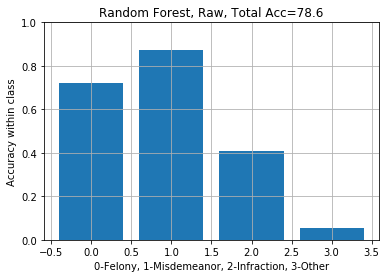

Wall time: 1min 52s


In [18]:
%%time
from sklearn.ensemble import RandomForestClassifier
maxAccRF = 0
optimalEstimatorsRF = 0
clReport = ''

for i in range(100, 201, 50):
    clf = RandomForestClassifier(n_estimators=i, n_jobs=-1, oob_score=True)

    # now iterate through and get predictions, saved to the correct row in yhat
    for train, test in cv.split(X,y):
        clf.fit(X[train],y[train])
        yhat[test] = clf.predict(X[test])
        
    total_accuracy = mt.accuracy_score(y, yhat)
    
    plt.title('Confusion Matrix for {0} estimators'.format(i), fontsize = 20)
    plt.imshow(mt.confusion_matrix(y, yhat),cmap=plt.get_cmap('Greens'),aspect='auto')
    plt.grid(False)
    plt.show()

    if total_accuracy > maxAccRF:
        maxAccRF = total_accuracy
        optimalEstimatorsRF = i
        optimalYRF = y
        optimalYhatRF = yhat
        clReport = mt.classification_report(y,yhat,digits=3)
        
#roc_auc_score(y_true, y_scores)


print ('Best accuracy is ', maxAccRF, ' with ', optimalEstimatorsRF, ' Estimators in a Raw Random Forest')
print(clReport)
plot_class_acc(optimalYRF,optimalYhatRF,title="Random Forest, Raw")

In [24]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score

num_estimators = 50
# lets train some trees
clf_array = [
    ('Stump',              DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)),
    ('Tree',               DecisionTreeClassifier()),
    ('Random Trees',       RandomForestClassifier(n_estimators=optimalEstimatorsRF)),
    ('Extra Random Trees', ExtraTreesClassifier(n_estimators=num_estimators,min_samples_split=2)),
    ('Boosted Tree',       GradientBoostingClassifier(n_estimators=num_estimators)), #takes a long time
    ]

for clf in clf_array:
    acc = cross_val_score(clf[1],X,y,cv=3)
    print (clf[0], acc.mean())

Stump 0.6708630668241665
Tree 0.7245850318854273
Random Trees 0.7851892678623579
Extra Random Trees 0.7693929764767712
Boosted Tree 0.7980138338176955
Wall time: 34.6 s


Pipeline accuracy 0.6520175164216453


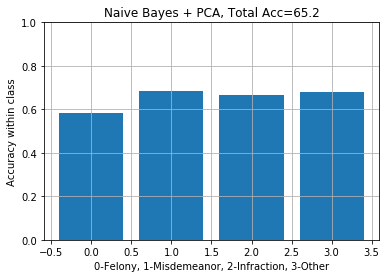

In [20]:
# from sklearn.svm import SVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB


# setup pipeline to take PCA, then fit a different classifier
clf_pipe = Pipeline(
    [('PCA',PCA(n_components=50,svd_solver='randomized')),
     ('CLF',GaussianNB())]
)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X,y):
    clf_pipe.fit(X[train],y[train])
    yhat[test] = clf_pipe.predict(X[test])

total_accuracy = mt.accuracy_score(y, yhat)
print ('Pipeline accuracy', total_accuracy)
plot_class_acc(y,yhat,title="Naive Bayes + PCA")

In [21]:
from sklearn import metrics as mt

freq_infreq_threshold = 3197

# get various measures of performance
total_accuracy = mt.accuracy_score(y, yhat)
per_class_acc_list = per_class_accuracy(y,yhat)

prec_for_freq_classes = []
recall_for_infreq_classes = []
rec_tot = []
prec_tot = []

for cls in np.unique(y):
    idx = (y==cls) # get classes
    ytmp_actual = np.zeros(y.shape) # make binary class problem
    ytmp_actual[idx] = 1 # set the instances for this specific class
    
    ytmp_predicted = np.zeros(y.shape) # binary prediction array
    ytmp_predicted[yhat==cls] = 1
    
    num_in_class = sum(idx)
    
    rec = mt.recall_score(ytmp_actual, ytmp_predicted)
    prec = mt.precision_score(ytmp_actual, ytmp_predicted)
    rec_tot.append(rec)
    prec_tot.append(prec)
    
    if num_in_class < freq_infreq_threshold:
        recall_for_infreq_classes.append(rec)
    elif num_in_class >= freq_infreq_threshold:
        prec_for_freq_classes.append(prec)
        
print ('Total Accuracy:',total_accuracy)
print ('Infractions & Other (Infrequent):',len(recall_for_infreq_classes), 
       'with average recall of:', np.mean(recall_for_infreq_classes))
print ('Felony & Misdemeanor (Frequent):',len(prec_for_freq_classes), 
       'with average precision of:',np.mean(prec_for_freq_classes))

Total Accuracy: 0.6520175164216453
Infractions & Other (Infrequent): 2 with average recall of: 0.6731675689694299
Felony & Misdemeanor (Frequent): 2 with average precision of: 0.7364493506493507


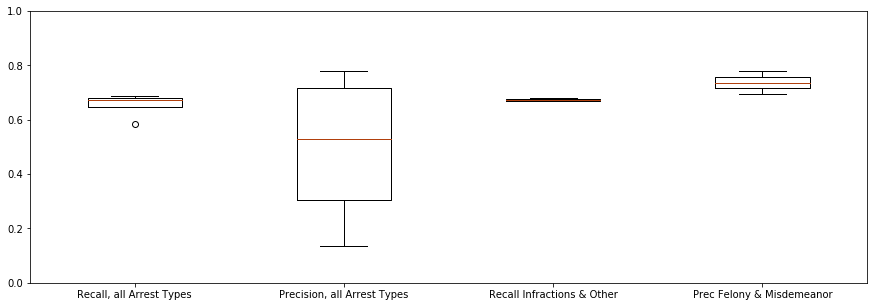

In [22]:
import seaborn as sns
sns.set_palette("dark")
plt.figure(figsize=(15,5))
plt.boxplot([ rec_tot, prec_tot, recall_for_infreq_classes,prec_for_freq_classes],
            labels=['Recall, all Arrest Types','Precision, all Arrest Types','Recall Infractions & Other','Prec Felony & Misdemeanor'])
plt.ylim([0,1])
plt.show()

In [23]:
#can't get this to work

import seaborn as sns
sns.set_palette("dark")
# code manipulated from http://scikit-learn.org/stable/auto_examples/plot_roc.html
from sklearn.preprocessing import label_binarize

# Compute ROC curve for a subset of interesting classes
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in [0,1,2,3]:
    fpr[i], tpr[i], _ = mt.roc_curve(y, yhat[:, i], pos_label=i)
    roc_auc[i] = mt.auc(fpr[i], tpr[i])

for i in np.random.permutation(4)[0:4]:
    plt.plot(fpr[i], tpr[i], label='class {0} with {1} instances (area = {2:0.2f})'
                                   ''.format(i, sum(y==i), roc_auc[i]))

plt.legend(loc="lower right")  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

IndexError: too many indices for array

<a id = 'Section_8'></a>

## 8. Modeling and Evaluation 4

*(10 points)*

*Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.*

<a id = 'Section_9'></a>

## 9. Modeling and Evaluation 5

*(10 points)*

*Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.*

<a id = 'Section_10'></a>

## 10. Modeling and Evaluation 6

*(10 points)*

*Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.*

<a id = 'Section_11'></a>

## 11. Deployment

*(5 points)*

*How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?*

<a id = 'Section_12'></a>

## 12. Exceptional Work

*(10 points)*

*You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?*

# code from minilab

### a. Futher Data Preparation for Logistic Regression and SVM

All categorical variables need to be dummy encoded. For example, if a variable has n different categories, we need to split this out to n-1 different variables. The code below does this for the categorical variables used in the model. The target variable `Arrest Type Code` is transformed to range from 0-3 instead of alphabetical letters representing the arrest type. Also, `Age` was bucketed into 10 year increments.

In [ ]:
# Encode Arrest Type Code as Categorical
cleanup_arrest = {"Arrest Type Code": {"F": 0, "M": 1, "I": 2, "O":3}}
df.replace(cleanup_arrest,inplace=True)

# Create buckets for Age
df['age_range'] = pd.cut(df.Age,[16,25,35,45,55,65,75,1e6],4,labels=[0,1,2,3,4,5,6]) # this creates a new variable
df['age_range'] = df.age_range.astype(np.int)

# Perform one-hot encoding of the categorical data "Descent Code"
tmp_df = pd.get_dummies(df['Descent Code'],prefix='Descent',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Replace the current Sex atribute with something slightly more intuitive and readable
df['IsMale'] = df['Sex Code']=='M' 
df.IsMale = df.IsMale.astype(np.int)

# Perform one-hot encoding of the categorical data "DOW"
tmp_df = pd.get_dummies(df['arrest_day_of_week'],prefix='DOW',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Perform one-hot encoding of the categorical data "Area ID"
tmp_df = pd.get_dummies(df['Area ID'],prefix='Area',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Perform one-hot encoding of the categorical data "Charge Group Code"
tmp_df = pd.get_dummies(df['Charge Group Code'],prefix='Charge',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Perform one-hot encoding of the categorical data "Hour"
tmp_df = pd.get_dummies(df['Hour'],prefix='Hour',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Perform one-hot encoding of the categorical data "Month"
tmp_df = pd.get_dummies(df['arrest_month'],prefix='Month',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

Next, we perform a check to see if there are any Charge Group Codes that have only one Arrest Type Code. For example, if the Charge Group Code referring to Murder is always associated with a Felony, we should not include these observations in the model. This would overinflate the model's accuracy.

In [ ]:
grps = df.groupby(['Charge Group Code','Arrest Type Code']).size()
grps1 = grps.groupby('Charge Group Code').count()
grps1[grps1 == 1]

Below, we remove any observations with Charge Group Codes of 3 (Robbery - Felony), 25 (Federal Offenses - Felony) or 99 (no description was provided in the dataset - Felony) since these are always associated with the same Arrest Type Code. We also remove any observations where no Charge Group Code was specified. 107,942 observations were removed from the dataset by filtering out these Charge Group Codes. The resulting dataset has 1,169,234 observations.

In [ ]:
#create another dataset for binary classification & SVM later
df_binary = df
df_svm = df

#filter charge group codes 
charge_codes_exclude= ['3.0','25.0','99.0','nan']
df = df[~df['Charge Group Code'].isin(charge_codes_exclude) ]

print("The filtered data set has {:,} rows and {:,} columns".format(*df.shape))

Now that the variables are all properly encoded, we remove the original variables from the dataset. We also remove `Reporting District` and `Location`. `Reporting District` has 1351 unique values and would be too cumbersome to include in our models. We instead use `Area ID`, where each Area ID is comprised of multiple Reporting Districts. We also remove `Location` which is GPS coordinates for the location of the incident, again in favor of `Area ID`.

Information about the resulting dataframe is printed for verification and the first 5 records are printed out.

In [ ]:
df.drop(['Sex Code','Descent Code','arrest_day_of_week','Area ID','Reporting District','Charge Group Code',
         'Location','arrest_year','Age','Hour','arrest_month'], axis=1, inplace=True)
df_logreg = df
df_logreg.info()

In [ ]:
df.head()

#### Correlation Matrix
Next we look at the correlation matrix for our encoded features. Two explanatory variables with high correlation between each other should not both be included in the model. In the plot below, axis labels have been omitted for clarity, but it does not hurt the visualization because there is very low correlation between the many encoded features.  The yellow line down the diagonal represents where each feature is compared to itself, so, of course, those correlations are 1 (and can be ignored because they are between the same variable). We do not see the need to remove any variables for multicollinearity reasons.

In [ ]:
# Take a look at the correlations between the many features in the data set
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
cb = plt.colorbar()
plt.title('Arrest Data Correlation Matrix', fontsize=16);

<a id = 'Section_3_b'></a>

### b. Logistic Regression

The section of code below sets up the frame for the logistic regression model. The target `Arrest Type Code` is identified as `y` and all other variables are assigned as explanatory variables `X`. We will be running multi-nomial Logistic Regression models since we have 4 Arrest Type Codes that we are trying to predict: Felony, Misdemeanor, Infraction, and Other.

In [ ]:
# we want to predict the X and y data as follows:
if 'Arrest Type Code' in df_logreg:
    y = df_logreg['Arrest Type Code'].values # get the labels we want
    del df_logreg['Arrest Type Code'] # get rid of the class label
    X = df_logreg.values # use everything else to predict!

We will use 3 different cross validation techniques to split the data and compare performance.
1. ShuffleSplit - use an 80%/20% training/test split. 3 iterations will be run. 
2. StratifiedShuffleSplit - use an 80%/20% training/test split. 3 iterations will be run. Here, the splits maintain the same percentages of each Arrest Type Code as the original dataset.
3. StratifiedKFold - dataset is split into 10 different groups and one group is left out each time. The splits maintain the same percentages of each Arrest Type Code as the original dataset.

In [ ]:
#Create the cross validation objects to be used in models
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,test_size  = 0.2,random_state=1234)
cv_object1 = StratifiedShuffleSplit(n_splits=num_cv_iterations, test_size=0.2, random_state=1234)
cv_object2 = StratifiedKFold(n_splits=10, random_state=1234)
                         
print(cv_object)
print(cv_object1)
print(cv_object2)

The code below creates a function to run the ShuffleSplit and the StratifiedShuffleSplit models to streamline testing multiple instances of each. The dataset is first split into train and test, then the explanatory variables are scaled. We do the scaling after the split so that we are not influencing scaling on observations in the test set. Finally, we fit the model with the training set and predict with the test set.

In [ ]:
def shufflesplits(estimator, cross_val_object):
    iter_num=0
    # the indices are the rows used for training and testing in each iteration
    for train_indices, test_indices in cross_val_object.split(X,y): 
        X_train = X[train_indices]
        y_train = y[train_indices]

        X_test = X[test_indices]
        y_test = y[test_indices]

        scl_obj = StandardScaler()
        scl_obj.fit(X_train)

        X_train_scaled = scl_obj.transform(X_train) # apply to training
        X_test_scaled = scl_obj.transform(X_test)

        # train the reusable logisitc regression model on the training data
        estimator.fit(X_train_scaled,y_train)  # train object
        y_hat = estimator.predict(X_test_scaled) # get test set precitions

        # now let's get the accuracy and confusion matrix for this iterations of training/testing
        print("====Iteration",iter_num," ====")
        print("accuracy", mt.accuracy_score(y_test,y_hat))
        print("precision", mt.precision_score(y_test,y_hat,average='weighted')) 
        print("recall", mt.recall_score(y_test,y_hat,average='weighted')) 
        print("confusion matrix\n",mt.confusion_matrix(y_test,y_hat))
        iter_num+=1

#### ShuffleSplit
First, we run the ShuffleSplit cross validation. We are using 2 options that are important for multi-nomial logistic regression: multi-class='multinomial' and class_weight='balanced'. Our data is not balanced between values of `Arrest Type Code`. 33.01% of the data are Felonies, 62.55% are Misdemeanors, 2.23% are Infractions and 2.22% are Other. Using class-weight='balanced' adjusts the weights to correspond to the occurrence of values of `Arrest Type Code` such that more emphasis will be placed on values of `Arrest Type Code` that occur most frequently. Here, more emphasis will be placed on Misdemeanor than Felony, and more emphasis will be placed on Felony than Infraction and Other.

Accuracy, precision, recall and the confusion matrix are printed out for each iteration of the model. Accuracy averages out to 64.43% over these 3 iterations. The most important incidents to correctly identify are Felonies. It is concerning here the large number of misclassifications of Felonies, especially those misclassified to Other.

For all models, the confusion matrices print in this order: Felony, Misdemeanor, Infraction, Other.

In [ ]:
%%time
lr_clf = LogisticRegression(multi_class='multinomial', solver='newton-cg',random_state=1234, class_weight='balanced')
shufflesplits(lr_clf,cv_object)

#### StratifiedShuffleSplit
Next, we run the StratifiedShuffleSplit cross validation using the same logistic regression model as before. Accuracy averages out to 64.49% over these 3 iterations, which is slightly higher than the ShuffleSplit cross validation.

In [ ]:
%%time
shufflesplits(lr_clf,cv_object1)

#### StratifiedKFold
For StratifiedKFold cross validation we create a separate function, which is slightly condensed. The function still splits the data into train and test datasets, and scales the explanatory variables after the split has been made. 

In [ ]:
def log_reg(estimator,cross_val_object):
    yhat=np.zeros(y.shape)
    std_scl = StandardScaler()

    # create the pipline
    piped_object = Pipeline([('scale', std_scl), ('logit_model', estimator)])

    # run the pipline corssvalidated
    for train, test in cross_val_object.split(X,y):
        piped_object.fit(X[train],y[train])  # train object
        yhat[test] = piped_object.predict(X[test])

    # it is a little odd getting trained objects from a  pipeline:
    trained_model_from_pipeline = piped_object.named_steps['logit_model']
    print("confusion matrix\n",mt.confusion_matrix(y,yhat))
    print("accuracy", mt.accuracy_score(y,yhat))
    print("precision", mt.precision_score(y,yhat,average='weighted'))
    print("recall", mt.recall_score(y,yhat,average='weighted'))

#### StratifiedKFold: solver='newton-cg'
For the first model of StratifiedKFold cross validation, we use the same model as before. Here we specify the penalty of 'l2' (which is the default). We will adjust various model parameters to see how they affect accuracy.

In [ ]:
%%time
lr_clf = LogisticRegression(multi_class='multinomial', penalty='l2', solver='newton-cg',random_state=1234, class_weight='balanced')
log_reg(lr_clf,cv_object2)

Below, we switch the penalty to 'none'. There are no other penalty options to choose from because solver 'newton-cg' only supports penalty 'l2' or 'none'. Accuracy is practically identical for both options of solver 'newton-cg'. It is interesting to note that the compute time increases by approximately 26 minutes.

In [ ]:
%%time
lr_clf = LogisticRegression(multi_class='multinomial', penalty='none', solver='newton-cg',random_state=1234, class_weight='balanced')
log_reg(lr_clf,cv_object2)

#### StratifiedKFold: solver='lbfgs'
Now we change solver to 'lbfgs'. We first run the model with penalty='l2'.

In [ ]:
%%time
lr_clf = LogisticRegression(multi_class='multinomial', penalty='l2', solver='lbfgs',random_state=1234, class_weight='balanced')
log_reg(lr_clf,cv_object2)

Here we again use solver='lbfgs', but we switch the penalty to 'none'. Solver 'lbfgs' only supports penalty 'l2' or 'none'. Accuracy is again practically the same for both penalty options of solver 'lbfgs'. Using solver 'lbfgs' does reduce the compute time by over an hour and twenty-two minutes as compared to the previous two models.

In [ ]:
%%time
lr_clf = LogisticRegression(multi_class='multinomial', penalty='none', solver='lbfgs',random_state=1234, class_weight='balanced')
log_reg(lr_clf,cv_object2)

#### StratifiedKFold: solver='sag'
Now we change the solver to 'sag'. Using a penalty of 'l2' reduces the accuracy to 63.05%, compared to the 63.08% we have seen with other models.

In [ ]:
%%time
lr_clf = LogisticRegression(multi_class='multinomial', penalty='l2', solver='sag',random_state=1234, class_weight='balanced')
log_reg(lr_clf,cv_object2)

Changing the penalty to 'none' increases the accuracy of the model to 63.09%, and it decreases the time from 44 minutes to 39 minutes.

In [ ]:
%%time
lr_clf = LogisticRegression(multi_class='multinomial', penalty='none', solver='sag',random_state=1234, class_weight='balanced')
log_reg(lr_clf,cv_object2)

#### StratifiedKFold: solver='saga'
Below we try out 3 models for solver='saga'. These models test different options for penalty: 'l2', 'l1', and 'elasticnet'. We use l1_ratio=.5 for penalty='elasticnet', which signifies a combination of L1 and L2. Again, we see that changing the solver and penalty, does not significantly change the accuracy performance of the model. The only thing that does change significantly is the compute time.

In [ ]:
%%time
lr_clf = LogisticRegression(multi_class='multinomial', penalty='l2', solver='saga',random_state=1234, class_weight='balanced')
log_reg(lr_clf,cv_object2)

In [ ]:
%%time
lr_clf = LogisticRegression(multi_class='multinomial', penalty='none', solver='saga',random_state=1234, class_weight='balanced')
log_reg(lr_clf,cv_object2)

In [ ]:
%%time
lr_clf = LogisticRegression(multi_class='multinomial', penalty='elasticnet', l1_ratio=.5, solver='saga',random_state=1234, class_weight='balanced')
log_reg(lr_clf,cv_object2)

#### StratifiedKFold: Changes in C
The following two blocks of code test different values for C using the 'lbfgs' solver. We use 'lbfgs' since this solver has been the fastest to compute and since the models all have very similar accuracies. We noticed that decreasing the `C` parameter to 1.5 decreased our compute time from 13 minutes 15 seconds from the fastest version of the model to 10 minutes and 36 seconds.

In [ ]:
%%time
lr_clf = LogisticRegression(multi_class='multinomial', C=.5, penalty='l2', solver='lbfgs',random_state=1234, class_weight='balanced')
log_reg(lr_clf,cv_object2)

In [ ]:
%%time
lr_clf = LogisticRegression(multi_class='multinomial', C=1.5, penalty='l2', solver='lbfgs',random_state=1234, class_weight='balanced')
log_reg(lr_clf,cv_object2)

#### Logistic Regression Winning Model

`Table 1` shows performance for each model run. We have chosen the StratifiedKFold model using solver='lbgfs', penalty='l2' and C='0.5' as the winning model. This is not the model with the highest accuracy. The increase in time from 11:05 to 35:45 of the model with the highest accuracy didn't seem worth the extra computing time, especially since the increase in accuracy was only 0.0047%.

#### Table 1: Logistic Regression Model Performance

| Cross Validation | Solver | Penalty | C | Time HH:MM:SS | Accuracy | Precision | Recall |
| :-- | :-- |  :-- | :-- | :-- | :-- | :-- | :-- |
| ShuffleSplit | newton-cg | l2 | 1 | 27:30 | 64.44% | 82.90% | 64.44% |
| StratifiedShuffleSplit | newton-cd | l2 | 1 | 23:24 | 64.49% | 82.93% | 64.50% |
| StratifiedKFold | newton-cg | l2 | 1 | 1:35:47 | 63.0815% | 82.3413% | 63.0815% |
| StratifiedKFold | newton-cg | none | 1 | 1:56:53 | 63.0814% | 82.3412% | 63.0814% |
| StratifiedKFold | lbfgs | l2 | 1 | 13:15 | 63.0824% | 82.3420% | 63.0824% |
| **StratifiedKFold** | **lbfgs** | **l2** | **0.5** | **11:05** | **63.0842%** | **82.3426%** | **63.0842%** |
| StratifiedKFold | lbfgs | l2 | 1.5 | 10:36 | 63.0817% | 82.3417% | 63.0817% |
| StratifiedKFold | lbfgs | none | 1 | 13:19 | 63.0820% | 82.3416% | 63.0820% |
| StratifiedKFold | sag | l2 | 1 | 43:45 | 63.0534% | 82.3439% | 63.0534% |
| StratifiedKFold | sag | none | 1 | 35:45 | 63.0889% | 82.3441% | 63.0889% |
| StratifiedKFold | saga | l2 | 1 | 47:01 | 63.0810% | 82.3411% | 63.0810% |
| StratifiedKFold | saga | none | 1 | 44:37 | 63.0810% | 82.3411% | 63.0810% |
| StratifiedKFold | saga | elasticnet | 1 | 1:11:51 | 63.0811% | 82.3412% | 63.0811% |

#### Table 2: Confusion Matrix

| Final Confusion Matrix | Predicted: Felony | Predicted: Misdemeanor | Predicted: Infraction | Predicted: Other |
| :-- | :-- | :-- | :-- | :-- |
| Actual: Felony | 286,161 | 40,424 | 2,781 |  56,563 |
| Actual: Misdemeanor | 86,899 | 404,041 | 114,731 | 125,631| 
| Actual: Infraction | 1,141 | 2,518 | 21,867 | 490 | 
| Actual: Other | 6 | 447 | 1 | 25,533| 

`Table 2` shows approximately 75% accuracy categorizing Felonies, 55% on Misdemeanors, 84% on Infractions, and 98% on Other. The relative strength of the logistic regression on Infractions and Other indicates that they have different associations with the predicting variables compared to Felonies and Misdemeanors. The number of samples for Felonies and Misdemeanors make up far larger portions of the data, so it is possible the uncertainty in classifying them has to do with the relatively greater variance of those two categories.

Felonies were about 33% of the total dataset, Misdemeanors 62%, Infractions and Other making up the remaining 5%. Higher accuracy on the categorization of the smaller populations may also be more accurate due to lack of overlap on charge codes. There are many charge codes, such as Charge_5 (Burglary), which are exclusively Felonies or Misdemeanors, with absolutely no Infractions or lesser charges. Only 9 of the possible 30 charges contain arrest labeled as Infractions, and those that do rarely also contain Felonies. Because of this, when using charge codes as an element of logistic regression, we can think of certain charge codes as highly indicative of an infraction or lesser charge because they exist in a fairly distinct space relative to the rest of the data that consists of arrests labeled as Felonies and Misdemeanors. This is further supported by the distribution of predictions for Felonies and Misdemeanors. In each column of the confusion matrix, most incorrect classifications for Felonies and Misdemeanors were Misdemeanors and Felonies, respectively. Compared to the small amount of either more serious arrest type that were classified as Infractions or Other, it seems that Felonies and Misdemeanors have more in common with each other than they do with the lesser charges.

Without delving into the mechanics of exactly what are the legal/financial/severity thresholds that separate various identical charges like homicide, burglary, rape, or vehicular theft into Felonies and Misdemeanors, it is difficult to determine if the "closeness" of felony and misdemeanor arrests are due to how more serious crimes are viewed by society/the judicial system or if there are other mitigating factors involved.

#### Extra: Binomial Logistic Regression
Before moving on to Support Vector Machines, we thought we would include some work we did with binomial logistic regression. We won't elaborate too much, but we were able to get significantly higher accuracy when only predicting Felonies and Misdemeanors. However, we choose to focus on multi-nomial models because this is more realistic. If our goal is to help prioritize calls a 911 dispatcher receives, it is not practical to only help predict some of the calls.

In [ ]:
#Exclude charge group codes that only appear with either Felony or Misdemeanor
charge_codes_exclude= ['3.0','18.0','19.0','25.0','27.0','29.0','99.0','nan']
df_binary = df_binary[~df_binary['Charge Group Code'].isin(charge_codes_exclude) ]
df_binary.drop(df_binary[df_binary['Arrest Type Code'] == 2].index, inplace = True) 
df_binary.drop(df_binary[df_binary['Arrest Type Code'] == 3].index, inplace = True) 

df_binary.drop(['Sex Code','Descent Code','arrest_day_of_week','Area ID','Reporting District','Charge Group Code',
         'Location','arrest_year','Age','Hour','arrest_month'], axis=1, inplace=True)

print("The filtered data set has {:,} rows and {:,} columns".format(*df_binary.shape))

In [ ]:
if 'Arrest Type Code' in df_binary:
    y = df_binary['Arrest Type Code'].values # get the labels we want
    del df_binary['Arrest Type Code'] # get rid of the class label
    X = df_binary.values # use everything else to predict!

In [ ]:
%%time
lr_clf = LogisticRegression(penalty='l2', solver='lbfgs',class_weight='balanced',random_state=1234) # get object
log_reg(lr_clf,cv_object2)

<a id = 'Section_3_c'></a>

### c. Support Vector Machine

In this section, we will explore support vector machines. First, a variety of SVM kernels are used, and we compare the results to see which ones are the most and least accurate. For the linear kernel, we can take the additional step of looking at the weights and plotting out the most meaningful.  Once we have the most accurate SVM model, which turns out to be RBF, we plot KDEs for all support vectors and compare that to their before state.  Finally, just for fun, we also look at a stochastic gradient descent (SGD) model. Interestingly, the SGD model performs about as well as the top models that don't use SGD.

One thing that we noticed right away is just how long it takes to train SVM models. We found that the training time grew exponentially as the size of the dataset grew, and we simply did not have enough time, after days of waiting, to use the full dataset in this section.  As a result, we opted to use a much smaller version of the dataset, which was built by randomly sampling 15% of data in the original dataset.  This resulted in 160,477 observations, which is much more manageable.

#### SVM Data Preparation
Now, we can take a few additional steps in the preparation of the data specifically for our analysis using SVM.  Certain charges are not helpful as data points and can be excluded.  Various categorical features should also be dropped since they have now all been one-hot encoded and so will be represented using their encoding for this part of the analysis.

The arrest type code is our predicted variable, which will also be removed from the analysis. We will use the rest of the features to improve our model's performance.

Out of the cross validation set, we split our data into train and test, as usual.  Then, we scale our predictors with a standard scalar before fitting the model.

Once this step is complete, we are ready to apply SVM with actual kernels and compare the results.

In [ ]:
#subsample of dataframe for svm testing, 5% of data
SUB_SAMPLE_SIZE = 0.15
df_svm1 = df_svm.sample(n = int(len(df) * SUB_SAMPLE_SIZE))

#filter charge group codes 
charge_codes_exclude= ['3.0','25.0','99.0','nan']
df_svm1 = df_svm1[~df_svm1['Charge Group Code'].isin(charge_codes_exclude) ]

df_svm1.drop(['Sex Code','Descent Code','arrest_day_of_week','Area ID','Reporting District','Charge Group Code',
         'Location','arrest_year','Age','Hour','arrest_month'], axis=1, inplace=True)

if 'Arrest Type Code' in df_svm1:
    y = df_svm1['Arrest Type Code'].values # get the labels we want
    del df_svm1['Arrest Type Code'] # get rid of the class label
    X = df_svm1.values # use everything else to predict!

for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]

    X_test = X[test_indices]
    y_test = y[test_indices]

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) 
X_train_scaled = scl_obj.transform(X_train) 
X_test_scaled = scl_obj.transform(X_test)

In [ ]:
y.shape

#### SVM Sigmoid Kernel
Now, we can start our SVM analysis.  Here we train a model using a Sigmoid kernel.  The sigmoid is a special function that is guaranteed to have a y-value constrained between 0 and 1 and crosses the y-axis at x=0.  Accuracy was better than logistic regression, at 74.25%, but we can do better.  The confusion matrix shows our predicted results across the four arrest types - Felony, Misdemeanor, Infraction, and Other (in this order).  This gives us a 4x4 matrix with the accurately predicted counts along the main diagonal.

In [ ]:
%%time
#sigmoid test
svm_clf = SVC(C=0.5, kernel='sigmoid', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

print('Sigmoid SVM Accuracy:', mt.accuracy_score(y_test,y_hat))
print("precision", mt.precision_score(y_test,y_hat,average='weighted'))
print("recall", mt.recall_score(y_test,y_hat,average='weighted'))
print(mt.confusion_matrix(y_test,y_hat))

#### SVM Linear Kernel

Note that linear is the simplest model to use conceptually, as it really is as simple as drawing a line between clusters of data points (or a plane in three dimensions, a cube in four, and so on).  The result is an accuracy of 76.86%, the highest yet.  In addition to the usual confusion matrix, we have also printed out the support vectors themselves and their n-value to study their shape for this dataset.

In [ ]:
%%time
# lets investigate SVMs on the data and play with the parameters and kernels

# train the model with a linear kernal
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

print('Linear SVM Accuracy:', mt.accuracy_score(y_test,y_hat))
print("precision", mt.precision_score(y_test,y_hat,average='weighted'))
print("recall", mt.recall_score(y_test,y_hat,average='weighted'))
print(mt.confusion_matrix(y_test,y_hat))

# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

#### SVM Linear Weights
Linear models also allow us to examine the weights, which would not make sense for non-linear models.  Here, we print out the weights and plot them.  In looking at the plot, it's obvious that many of these weights essentially contribute nothing to our model.  You can tell that, too, by looking at some of the weight matrices.  Many of the values are extremely small - on the order of e-5 or e-6, which is very close to zero.  As such, we will want to prune these down quite a bit to focus on the ones that provide value.

In [ ]:
# Look at the weights for linear SVM
print(svm_clf.coef_)
weights = pd.Series(svm_clf.coef_[0],index=df.columns)
weights.plot(kind='bar')

In [ ]:
weights.sort_values()

#### SVM Significant Linear Weights
There are many categories that have practically no weight at all(absolute value less than 0.0001). Filtering out values with abs < .01 takes us from 93 weights to 15.  The plot below shows this graphically and shows visually which weights do carry the greatest impact.

Only charge related categories remain after filtering for weights with an absolute value greater than 0.01, so we can infer that the excluded fields, hour, area, day of week, and even descent code, are all less useful than the charge type in finding the ideal separating hyperplane between the various types of arrests. However, this may be a reflection of the data, which contains significant overlap between certain charge types and arrest types. As an example, charge_4.0 is Aggravated Assault, which is almost always a Felony.

In [ ]:
#filter and regraph
weights = pd.Series(svm_clf.coef_[0],index=df.columns)
weights_filtered = weights[abs(weights) > 0.01]
len(weights_filtered)
weights_filtered.plot(kind='bar')

#### SVM Polynomial Kernel
Next, we use the polynomial kernel, which allows us to learn a non-linear model.  We can specify the degree (i.e. the highest number of exponents of the polynomial).  In this case, we chose to go with 3.  While higher order polynomials would result in better accuracy, they would likely overfit the model, thus making it a poor predictor.

Once fit, we look at the test results and find that this model results in about 81% accuracy.  This is significantly better than the accuracy results from logistic regression.

In [ ]:
%%time
#poly test
svm_clf = SVC(C=0.5, kernel='poly', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

print('Poly SVM Accuracy:', mt.accuracy_score(y_test,y_hat))
print("precision", mt.precision_score(y_test,y_hat,average='weighted'))
print("recall", mt.recall_score(y_test,y_hat,average='weighted'))
print(mt.confusion_matrix(y_test,y_hat))

#### Stochastic Gradient Descent
Just to see what the differences might be, we also tried a model with SGD.  Much like SVM, this also involved the use of some scaling before getting the test set prediction.  The results and confusion matrix show that accuracy with this method was as good as with SVM using and RBF kernel.  While performance in this analysis was very similar for both models, using SGD could result in better performance since it doesn't explode exponentially the way that the SVM algorithm does.

In [ ]:
%%time
# Linear SVM classifier with Stochastic Descent
from sklearn.linear_model import SGDClassifier

regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()

svm_sgd.fit(scl.fit_transform(X_train_scaled),y_train)
yhat = svm_sgd.predict(scl.transform(X_test_scaled))

svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

print('SVM w/Stochastic Descent:', mt.accuracy_score(y_test,y_hat))
print("precision", mt.precision_score(y_test,y_hat,average='weighted'))
print("recall", mt.recall_score(y_test,y_hat,average='weighted'))
print(mt.confusion_matrix(y_test,y_hat))

# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

#### SVM Radial Basis Function Kernel
For our final SVM model, we use RBF, which, much like sigmoid, ranges between 0 and 1.  It measures the distance between points and the support vectors, and another useful property is that RBF decreases with distance.  The result is an accuracy 81.12%.

In [ ]:
%%time
# train the model just as before with an rbf kernal
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

print('RBF SVM Accuracy:', mt.accuracy_score(y_test,y_hat))
print("precision", mt.precision_score(y_test,y_hat,average='weighted'))
print("recall", mt.recall_score(y_test,y_hat,average='weighted'))
print(mt.confusion_matrix(y_test,y_hat))

# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

#### SVM Winning Model
`Table 3` summarizes model performance for the SVM models we ran. About 81% accuracy for kernel types RBF and Poly. On this dataset, polynomial appears to take most time/computational resources with sigmoid the least. The RBF (gaussian) approach is slightly more accurate than the rest, which may indicate that the ideal separating hyperplane that can be used to categorize arrest type codes is nonlinear.

#### Table 3: SVM Model Performance

| Model | Time HH:MM:SS | Accuracy | Precision | Recall |
| :-- | :-- | :-- | :-- | :-- |
| Stochastic Descent (rbf kernel) | 1:29:29 | 80.96% | 79.05% | 80.96% |
| **Linear SVM (rbf kernel)** | 1:15:50 | **80.96%** | **79.05%** | **80.96%** |
| Polynomial SVM | 1:19:25 | 80.95% | 78.95% | 80.95 | 
| Linear SVM | 1:06:26 | 80.49% | 76.86% | 80.49% |
| Sigmoid SVM | 31:38 | 74.25% | 71.22% | 74.25% |

<a id = 'Section_4'></a>

## 4. Model Advantages

*(10 points)*

*Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.*

#### Logistic Regression

- **Advantages**: Simple and interpretable model. Can classify and also give you probabilites. Computationally inexpensive. Good baseline to compare more complex models. Easy to regularize (shrink coeffiicent estimates to zero to avoid overfitting).  


- **Disadvantages**: Performace suffers when there are multiple non-linear decision boundaries. 

For our dataset, the logistic regression model performed much worse than all SVM models. The logistic regression model was even built with more data than the SVM models. The computing time for our logistic regression models was significantly less than the SVM models.

#### Support Vector Machine

- **Advantages**: Highly accurate. Can model non-linear decision boundaries. Can work well on smaller datasets (i.e., doesn't need millions of observations). Generalizes well. Tends to avoid overfitting and works well when identifying boundary regions.     


- **Disadvantages**: Training time with SVMs can be high. Less effective on noisier datasets with overlapping classes. Requires selection of the kernel function parameters (i.e. you have to provide the true structure of the data as an input). Requires tuning the parameters for the kernels and the C parameter, which can be time consuming and decrease the performance if done improperly.  

For our dataset, the computing time required for SVM models was an issue. We wanted to test a wide variety of models, but when some of them take hours to run (on just 15% of the data), we were limited in what we could actually acoomplish. We spent days trying to get the full dataset to run through an SVM model before we had to give up and sample the dataset. The advantage of the SVM models for our dataset was the huge gain in accuracy. The logistic regression models were not accurate enough, in our opinion, to actually be useful.

<a id = 'Section_5'></a>

## 5. Interpret Feature Importance

*(30 points)*

*Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?*

Below we re-run the winning logistic regression model.

In [ ]:
%%time

lr_clf = LogisticRegression(multi_class='multinomial', C=.5, penalty='l2', solver='lbfgs',random_state=1234, class_weight='balanced')
yhat=np.zeros(y.shape)
std_scl = StandardScaler()

# create the pipline
piped_object = Pipeline([('scale', std_scl), ('logit_model', lr_clf)])

# run the pipline crossvalidated
for train, test in cv_object2.split(X,y):
    piped_object.fit(X[train],y[train])  # train object
    yhat[test] = piped_object.predict(X[test])

# it is a little odd getting trained objects from a  pipeline:
trained_model_from_pipeline = piped_object.named_steps['logit_model']
print("confusion matrix\n",mt.confusion_matrix(y,yhat))
print("accuracy", mt.accuracy_score(y,yhat))
print("precision", mt.precision_score(y,yhat,average='weighted'))
print("recall", mt.recall_score(y,yhat,average='weighted'))

Here we sort the weights by absolute value and print out the coefficients.

In [ ]:
# sort these attributes and spit them out
zip_vars = zip(trained_model_from_pipeline.coef_[0],df_logreg.columns) # combine attributes
zipped = list(zip_vars) 
zipped = sorted(zipped,key = lambda t: np.abs(t[0]), reverse=True)
for coef, name in zipped:
    print(name, 'has weight of', coef) # now print them out

The plot below displays the most important features in the logistic regression model. We used a cut-off of .1 for the absolute value of the weights. This is due to the large number of explanatory variables, and the fact that the majority of them have weights very close to zero.

In [ ]:
# now let's make a pandas Series with the names and values, and plot them
%matplotlib inline

weights = pd.Series(trained_model_from_pipeline.coef_[0],index=df_logreg.columns)
weights_filter = weights[weights.abs() >= 0.1]
weights_final = weights_filter.iloc[weights_filter.abs().argsort()]

x = weights_final.index
y = weights_final.values

fig, ax = plt.subplots(figsize=(10,10))
ax.barh(x,y, color='blue')
#ax.margins(0.05)
ax.set_ylim(bottom=-2.5)

Per the Logistic Regression Feature Importance chart above, we can see that the six most important features are Charge_18 (Drunkeness), Charge_24 (Misc Other Violations), Charge_17 (Liquor Laws), Charge_20 (Disorderly Conduct), Charge_4 (Aggravated Assault), and Charge_23 (Moving Traffic Violations). 

The only 2 original variables that show up in the top weights are related to `Charge Group Code` and `Area ID`. Surprisingly, we don't see any variables for gender, descent or age.

Since all explanatory variables are continuous, we have only interpreted in detail 2 of the most important features (a negative and positive weight coefficient). All other weights would follow the same interpretation pattern.
* The odds ratio of an incident being a felony when the charge group code is 18 (Drunkeness) relative to when it's not 18 is 0.03867. The odds of an incident being a Felony when the charge group code is 18 is 96.13% less than the odds when it isn't 18. Looking at the data, most of the incidents with charge group code of 18 are Misdemeanors.
* The odds ratio of an incident being a felony when the charge group code is 4 (Aggravated Assault) relative to when it's not 4 is 0.70928. The odds of an incident being a Felony when the charge group code is 4 is 2.3 times higher than the odds when it isn't 4. Looking at the data, most of the incidents with charge group code of 4 are Felonies.

Liquor related offenses were 70% misdemeanors and 30% infractions, with almost no felonies. Drunkeness related offenses were curiously seperate from liquor related ones, and consisted of 95% misdemeanors, 5% infractions, and no felonies. All of these charges correspond strongly to one or more arrest types, so it makes sense that these features are useful.

This does bring up possible overlap issues between certain charge types and arrest types. Some charge groups are almost completely uniform, such as charge 21, gambling, which is 99.5% misdemeanors. However, such charge groups are also very small, making up only about .2% of the arrest data. While the uniformity of arrest types is not as absolute for the largest categories, it does lean strongly in certain directions. It's not quite a one to one/directly correlated variable to target classification variable, but it might be too close to be useful.  

<a id = 'Section_6'></a>

## 6. Interpret Support Vectors

*(10 points)*

*Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.*

To look at the support vectors for the winning RBF model, we need to first do some data prep by creating a fresh copy of the dataset and adding back in our arrest type code (the predicted variable).  This will allow us to perform some "before" and "after" comparisons on the support vectors and their base data.

In [ ]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors
# make a dataframe of the training data
df_tested_on = df_svm1.iloc[train_indices].copy() # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:].copy()

df_support['Arrest Type Code'] = y[svm_clf.support_] # add back in the 'Arrest Type Code' Column to the pandas dataframe
df_svm1['Arrest Type Code'] = y # also add it back in for the original data

With our model and prepared data in hand, we can now compare the original data with the support vectors that were chosen. We do this by plotting all of the plottable features in the dataset and excluding a few, like the predicted feature, age range, and charge codes that do not contribute anything to the model or our understanding.

In [ ]:
from pandas.plotting import boxplot

# Group the original data and the support vectors
df_grouped_support = df_support.groupby(['Arrest Type Code'])
df_grouped = df_svm.groupby(['Arrest Type Code'])

# Plot KDE of Different variables
vars_to_plot = df_support.columns.tolist()
vars_to_plot.pop()  # Drop last feature, arrest type code, it would make no sense to plot
vars_to_plot.pop(0) # Drop first feature, age_range, which makes no sense in this plot
vars_to_plot = list(filter(lambda item: ('Charge_' not in item) &  
                                        ('Hour_5' not in item), vars_to_plot))
for v in vars_to_plot:
    try:
        plt.figure(figsize=(10,4))
        # plot support vector stats
        plt.subplot(1,2,1)
        ax = df_grouped_support[v].plot.kde() 
        plt.legend(['Felony','Misdemeanor','Infraction','Other'])
        plt.title(v+' (Instances chosen as Support Vectors)')

        # plot original distributions
        plt.subplot(1,2,2)
        ax = df_grouped[v].plot.kde() 
        plt.legend(['Felony','Misdemeanor','Infraction','Other'])
        plt.title(v+' (Original)')
    except:
        continue  # If a feature isn't plottable, just ignore it and move on

The support vectors show a generally reduced density and a flattening of the curve for each type of arrest code. Please note that the plot scales vary slightly; this can give the impression that some densities are greater when that is usually not the case.

Another interesting thing to note is that the separation between the distributions in the support vectors is not as great as between the orignal data. This is because support vectors tend to be along the boundaries between clusters, and they can also be affected by outliers.

The support vectors revealed that certain charge codes were highly predictive in determing what the arrest code would be.  This is what you might expect given that if someone is arrested for, say, murder, the resulting classification would, of course, be a felony.  Other features did not provide nearly as much insight, at least as far as the support vectors are concerned.  These include such things as the age, area, and various time-related features, which is a somewhat surprising result.

Support vector and gradient descent resulted in very similar accuracy, which was also a surprise.  We thought that support vectors would beat gradient descent easily, but this was not the case here.  It may be true in other instances, however, so it would be best to always check both types as well as looking at the various types of SVM kernels to identify the most appropriate model to use.

Similar to in the logistic regression model, there were several variables that we thought would be of more importance such as descent, gender and age. Instead we found that `Charge Group Code` and `Area ID` variables have the highest importance.